In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk.data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import os

!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')

train['tokens'] = train['Text'].apply(preprocess_text)

print(train)



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

To begin, we are applying a function preprocess_text to all records in the training data. This function will take each headline, and distill it into a series of tokens. The tokenization process involves converting every word to strict lower-case, removing any punctuation, removing any stopwords (a stopword would be words such as "and" or "or"), finally simplifying words to their base form (ie "expanding" -> "expand"). Our data frame will now have a 4th column tokens, which has each tokenized word arranged in an array.

We'll also take a look at some word statistics of these tokens, such as the average word count per headline, average word length per headline, and average stopword count of each headline.

# Sources MOVE TO BOTTOM
Pipis, G. (2021, January 24). Topic modelling with NMF in Python. Predictive Hacks. https://predictivehacks.com/topic-modelling-with-nmf-in-python/

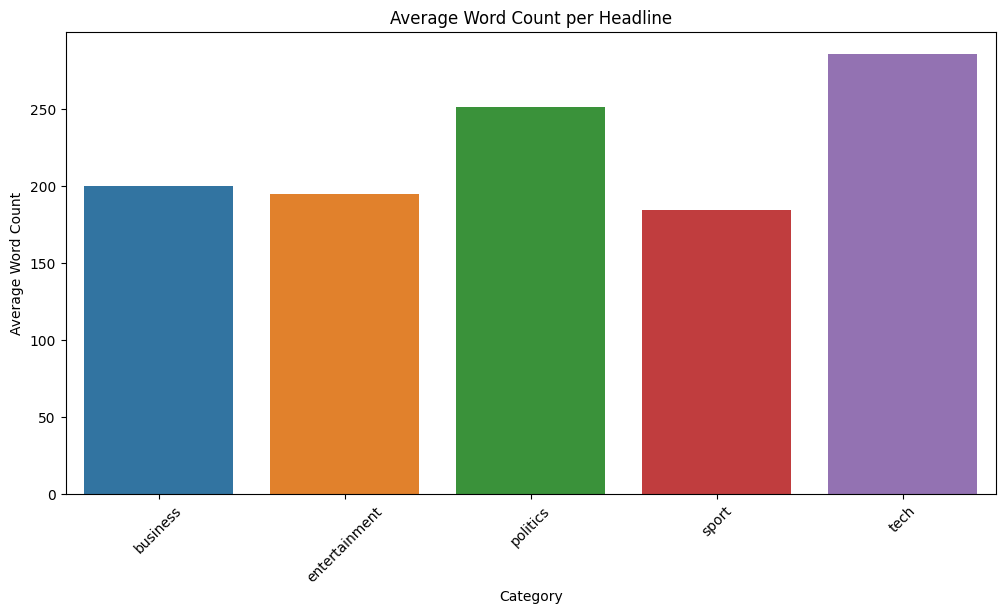

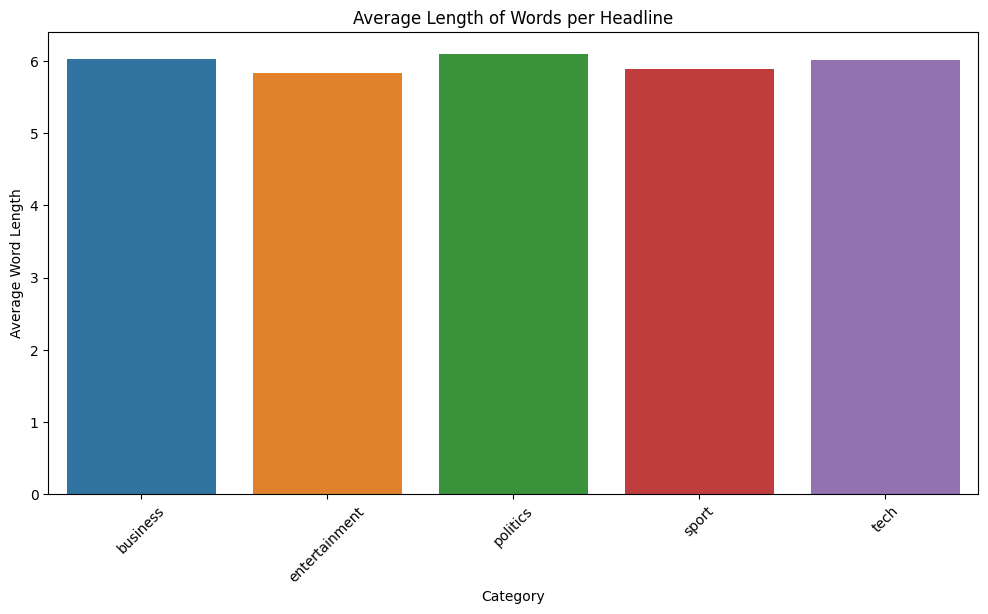

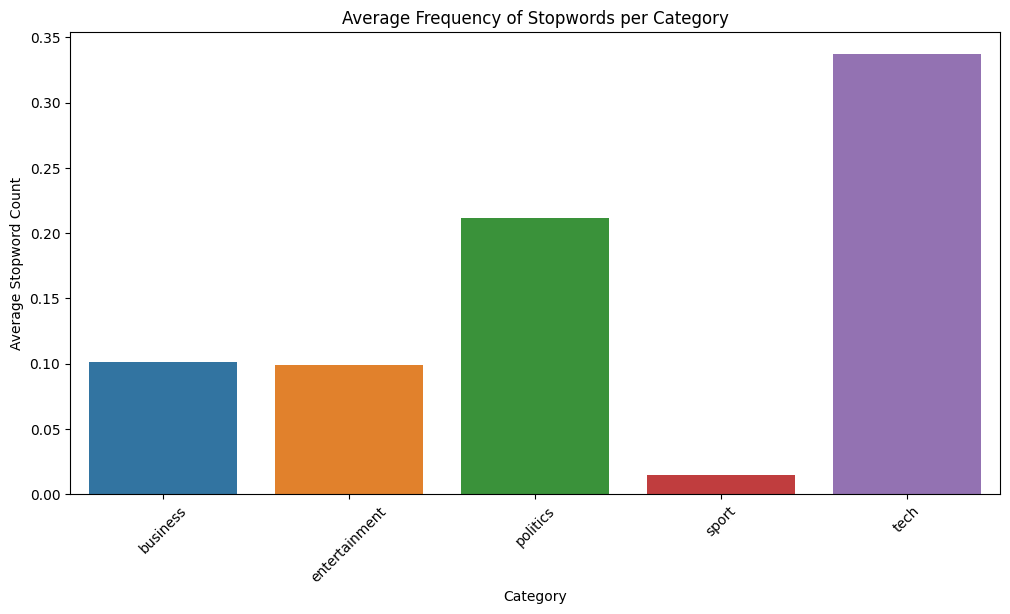

In [2]:
stop_words = set(stopwords.words('english'))


# Calculate average word count per headline
train['word_count'] = train['tokens'].apply(len)
avg_word_count_per_headline = train.groupby('Category')['word_count'].mean().reset_index()

# Calculate average length of words per headline
train['avg_word_length'] = train['tokens'].apply(lambda tokens: np.mean([len(word) for word in tokens]))
avg_length_per_headline = train.groupby('Category')['avg_word_length'].mean().reset_index()

# Calculate average frequency of stopwords per category
train['stopword_count'] = train['tokens'].apply(lambda tokens: sum(1 for word in tokens if word in stop_words))
avg_stopwords_per_category = train.groupby('Category')['stopword_count'].mean().reset_index()


# Average Word Count per Headline
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='word_count', data=avg_word_count_per_headline)
plt.title('Average Word Count per Headline')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.xticks(rotation=45)
plt.show()

# Average Length of Words per Headline
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='avg_word_length', data=avg_length_per_headline)
plt.title('Average Length of Words per Headline')
plt.xlabel('Category')
plt.ylabel('Average Word Length')
plt.xticks(rotation=45)
plt.show()

# Average Frequency of Stopwords per Category
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='stopword_count', data=avg_stopwords_per_category)
plt.title('Average Frequency of Stopwords per Category')
plt.xlabel('Category')
plt.ylabel('Average Stopword Count')
plt.xticks(rotation=45)
plt.show()

It would seem tech headlines have quite a bit more stopwords on average, and sport headlines minimal. Some differences as well for the average wordcount per headline.

In [3]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50, stop_words='english')
 
# Fit and transform
X = vect.fit_transform(train.Text)


In [4]:

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=5, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

print(nmf_features)



[[0.07136206 0.         0.00877761 0.00567975 0.09060687]
 [0.         0.         0.         0.         0.19370839]
 [0.0169142  0.02048571 0.03441909 0.         0.11680253]
 ...
 [0.         0.01259644 0.         0.01155169 0.21037455]
 [0.         0.         0.21572181 0.01147775 0.04057271]
 [0.         0.01405392 0.13552191 0.         0.00854267]]


In [5]:
from sklearn.metrics import accuracy_score

print(X.shape)
print(nmf_features.shape)
print(model.components_.shape)

components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())
components_df


def pred(text,vect,model):
    X = vect.transform([text])
    nmf_features = model.transform(X)
    return pd.DataFrame(nmf_features).idxmax(axis=1)

train['predict'] = train['Text'].apply(pred, vect=vect,model=model)
test['predict'] = test['Text'].apply(pred, vect=vect,model=model)



d_test = {'business':[0,0,0,0,0],'politics':[0,0,0,0,0],'entertainment':[0,0,0,0,0],'sport':[0,0,0,0,0],'tech':[0,0,0,0,0]}
d_train = {'business':[0,0,0,0,0],'politics':[0,0,0,0,0],'entertainment':[0,0,0,0,0],'sport':[0,0,0,0,0],'tech':[0,0,0,0,0]}

for index, row in test.iterrows():

    d_test[row['Category']][row['predict']] = d_test[row['Category']][row['predict']] +1
    
for index, row in train.iterrows():
    d_train[row['Category']][row['predict']] = d_train[row['Category']][row['predict']] +1
      

mapping = {
    0: 'sport',
    1: 'politics',
    2: 'tech',
    3: 'entertainment',
    4: 'business'
}

test['pred_category'] = test['predict'].map(mapping)
train['pred_category'] = train['predict'].map(mapping)
accuracy_test = accuracy_score(test['Category'], test['pred_category'])
accuracy_train = accuracy_score(train['Category'], train['pred_category'])

print(f"Accuracy: {accuracy_test:.2f}",d_test)
print(f"Accuracy: {accuracy_train:.2f}",d_train)

(1490, 937)
(1490, 5)
(5, 937)
Accuracy: 0.50 {'business': [9, 1, 11, 1, 314], 'politics': [221, 5, 22, 1, 25], 'entertainment': [5, 23, 43, 178, 24], 'sport': [0, 342, 0, 2, 2], 'tech': [0, 9, 241, 4, 7]}
Accuracy: 0.50 {'business': [9, 1, 11, 1, 314], 'politics': [221, 5, 22, 1, 25], 'entertainment': [5, 23, 43, 178, 24], 'sport': [0, 342, 0, 2, 2], 'tech': [0, 9, 241, 4, 7]}


Our accuracy is only 50%. Let's try tweaking the min_df hyperparameter. We'll increase the parameter in increments of 10 words and record the accuracy.

Test accuracy with parameter 150: 0.19 {'business': [231, 56, 1, 2, 46], 'politics': [2, 198, 0, 3, 71], 'entertainment': [19, 14, 134, 23, 83], 'sport': [7, 3, 1, 319, 16], 'tech': [9, 7, 3, 36, 206]}
Train accuracy with parameter 150: 0.19 {'business': [231, 56, 1, 2, 46], 'politics': [2, 198, 0, 3, 71], 'entertainment': [19, 14, 134, 23, 83], 'sport': [7, 3, 1, 319, 16], 'tech': [9, 7, 3, 36, 206]}
Test accuracy with parameter 125: 0.37 {'business': [7, 33, 1, 2, 293], 'politics': [27, 213, 1, 7, 26], 'entertainment': [37, 11, 144, 36, 45], 'sport': [4, 3, 0, 328, 11], 'tech': [163, 10, 4, 35, 49]}
Train accuracy with parameter 125: 0.37 {'business': [7, 33, 1, 2, 293], 'politics': [27, 213, 1, 7, 26], 'entertainment': [37, 11, 144, 36, 45], 'sport': [4, 3, 0, 328, 11], 'tech': [163, 10, 4, 35, 49]}
Test accuracy with parameter 100: 0.19 {'business': [271, 39, 1, 2, 23], 'politics': [9, 223, 0, 3, 39], 'entertainment': [15, 12, 147, 27, 72], 'sport': [3, 3, 1, 337, 2], 'tech': [9, 4

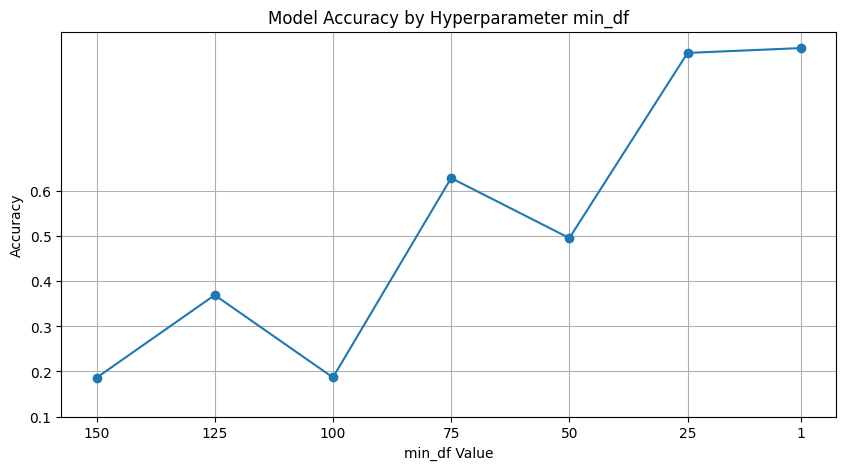

In [6]:

def increment_hyperparameter(train,test,h):
    vectB = TfidfVectorizer(min_df=h, stop_words='english')
    # Fit and transform
    X = vectB.fit_transform(train.Text)
    model = NMF(n_components=5, random_state=5)
    # Fit the model to TF-IDF
    model.fit(X)
    # Transform the TF-IDF: nmf_features
    nmf_features = model.transform(X)
    train['predict'] = train['Text'].apply(pred,vect=vectB,model=model)
    test['predict'] = test['Text'].apply(pred,vect=vectB,model=model)



    d_test = {'business':[0,0,0,0,0],'politics':[0,0,0,0,0],'entertainment':[0,0,0,0,0],'sport':[0,0,0,0,0],'tech':[0,0,0,0,0]}
    d_train = {'business':[0,0,0,0,0],'politics':[0,0,0,0,0],'entertainment':[0,0,0,0,0],'sport':[0,0,0,0,0],'tech':[0,0,0,0,0]}

    for index, row in test.iterrows():

        d_test[row['Category']][row['predict']] = d_test[row['Category']][row['predict']] +1
    
    for index, row in train.iterrows():
        d_train[row['Category']][row['predict']] = d_train[row['Category']][row['predict']] +1

    mapping = {
        0: 'sport',
        1: 'politics',
        2: 'tech',
        3: 'entertainment',
        4: 'business'
    }

    test['pred_category'] = test['predict'].map(mapping)
    train['pred_category'] = train['predict'].map(mapping)
    accuracy_test = accuracy_score(test['Category'], test['pred_category'])
    accuracy_train = accuracy_score(train['Category'], train['pred_category'])

    print(f"Test accuracy with parameter {h}: {accuracy_test:.2f}",d_test)
    print(f"Train accuracy with parameter {h}: {accuracy_train:.2f}",d_train)
    return accuracy_test
    

hyperparameters = [150,125,100,75,50,25,1]
accuracy = []

for h in hyperparameters:
    accuracy.append(increment_hyperparameter(train,test,h))

plt.figure(figsize=(10, 5))
plt.plot(hyperparameters, accuracy, marker='o') 
plt.title('Model Accuracy by Hyperparameter min_df')
plt.xlabel('min_df Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(hyperparameters)  
plt.yticks([i * 0.1 for i in range(1, 7)])  
plt.gca().invert_xaxis()  
plt.show()


It's an interesting zig-zag pattern we see as we move from a minimum of 150 to 25.

# Step 3: Compare With Supervised Learning

Let's try Logistic Regression and Random Forest and see the results. For each model, we'll iteratively try using 10%, 20%, 50% of the data for test and see how the performance changes.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')

combined_df = pd.concat([train, test], ignore_index=True)
df = combined_df.sample(frac=1, random_state = 42).reset_index(drop=True)
print(df)
y = df['Category']
X_init = df.drop(columns='Category')

y = label_encoder.fit_transform(y)

vect = TfidfVectorizer(min_df=200, stop_words='english')
 
# Fit and transform
X = vect.fit_transform(X_init.Text)



      ArticleId                                               Text  Category
0          1034  labour s  eu propaganda  a  taxpayer subsidise...  politics
1          1111  what high-definition will do to dvds first it ...      tech
2           689  lions blow to world cup winners british and ir...     sport
3          1497  klinsmann issues lehmann warning germany coach...     sport
4          2157  dallaglio his own man to the end controversy a...     sport
...         ...                                                ...       ...
2975         91  slovakia reach hopman cup final slovakia will ...     sport
2976       2170  goldsmith denies war advice claim the attorney...  politics
2977        193  blair  said he would stand down  tony blair pr...  politics
2978        111  us trade gap hits record in 2004 the gap betwe...  business
2979        833  tories pledge free sports lessons children wou...  politics

[2980 rows x 3 columns]


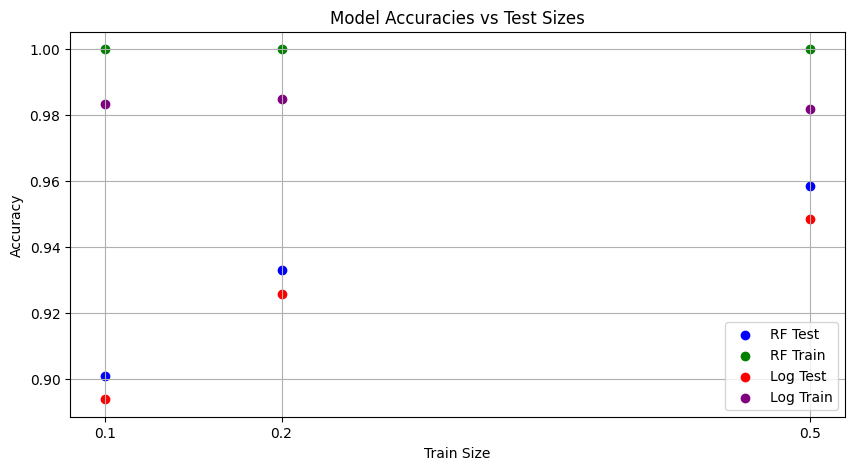

In [8]:
test_sizes = [0.1,0.2,0.5]
clf_test_acc = []
clf_train_acc = []
log_test_acc = []
log_train_acc = []

for size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    log = LogisticRegression()
    clf.fit(X_train, y_train)
    log.fit(X_train, y_train)
    clf_pred_test = clf.predict(X_test)
    log_pred_test = log.predict(X_test)
    clf_pred_train = clf.predict(X_train)
    log_pred_train = log.predict(X_train)
    clf_test_acc.append(accuracy_score(clf_pred_test,y_test))
    clf_train_acc.append(accuracy_score(clf_pred_train,y_train))
    log_test_acc.append(accuracy_score(log_pred_test,y_test))
    log_train_acc.append(accuracy_score(log_pred_train,y_train))
    
colors = ['blue', 'green', 'red', 'purple']  # Colors for each series
labels = ['RF Test', 'RF Train', 'Log Test', 'Log Train']  # Labels for each series

plt.figure(figsize=(10, 5))
plt.scatter(test_sizes, clf_test_acc, color=colors[0], label=labels[0])
plt.scatter(test_sizes, clf_train_acc, color=colors[1], label=labels[1])
plt.scatter(test_sizes, log_test_acc, color=colors[2], label=labels[2])
plt.scatter(test_sizes, log_train_acc, color=colors[3], label=labels[3])

plt.title('Model Accuracies vs Test Sizes')
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.xticks(test_sizes)
plt.legend()
plt.grid(True)
plt.show()

Overall, we have very good results from both methods. It would appear the most data-efficient would be the random forest - just over 90% accuracy using only 10% of the data for training. Logistic regression is not far behind, at nearly 90%.

We set the min_df parameter to 100, so that the model would only train on words that appear in a minimum of 200 headlines. This helps prevent training the model on "noise" and overfitting. 

These methods appear to work better than matrix factorization, as by default we had a 50-50 train/test split, and using a similar min_df, we had much lower accuracy.